<a href="https://colab.research.google.com/github/karthikmohan1702/EVA6/blob/main/S7_Advanced_concepts/S7_Dilated_Depthwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

!pip install torchsummary
!pip install -U albumentations

     |████████████████████████████████| 102kB 6.5MB/s 
     |████████████████████████████████| 38.2MB 79kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.listdir()

['.config', 'drive', 'sample_data']

In [4]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/model/")
sys.path.append("/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/load_data/")
sys.path.append("/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/augmentations/")
sys.path.append("/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/utils/")
sys.path.append("/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/visualization/")
sys.path.append("/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/train_test/")

In [5]:
from cifar10_model import cifar10_Net
import data_loader
import data_augment

### Albumentations

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.2),
        A.augmentations.geometric.transforms.ShiftScaleRotate (shift_limit=0.0625, 
                                                               scale_limit=0.1, 
                                                               rotate_limit=10, 
                                                               ),
        # A.Cutout(num_holes=1, max_h_size=16, max_w_size=16, always_apply=False),
        A.CoarseDropout (max_holes=1, max_height=16, max_width=16, min_holes=1, 
                          min_height=16, min_width=1, fill_value=[0.4914, 0.4822, 0.4465], 
                          mask_fill_value=None),
        A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ToTensorV2()
    ]
)

test_transform = A.Compose([A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ToTensorV2()])

### Downloading Dataset & loading on dataloader

In [7]:
from data_loader import cifar10_dataset

trainset= cifar10_dataset(transform= train_transform)
testset= cifar10_dataset(train= False, transform= test_transform)
batch_size = 128

train_loader, test_loader = data_loader.train_test_loader(trainset, testset, batch_size)


Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10
Files already downloaded and verified


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  cat   dog  ship   cat


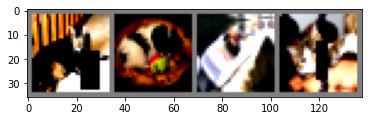

In [8]:
# Loading dataset to view sample images
sample_data_loader = data_loader.dummy_loader(cifar10_dataset(transform= train_transform), batch_size=4)

import plotting
plotting.plot_sample_img(sample_data_loader, data_class = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))

### Summary of the model

In [9]:
import utils_func
utils_func.get_model_summary(model=cifar10_Net(), input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           1,056
           Conv2d-10           [-1, 32, 14, 14]           9,248
           Conv2d-11           [-1, 64, 12, 12]          18,496
      BatchNorm2d-12           [-1, 64, 12, 12]             128
             ReLU-13           [-1, 64, 12, 12]               0
          Dropout-14           [-1

/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/model/cifar10_model.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


### Model Training

In [10]:
import train
import test
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from tqdm import tqdm
import utils_func

train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 100

device = utils_func.get_device_info()

model =  cifar10_Net(dropout_value=0.04).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = OneCycleLR(optimizer, max_lr=0.05, epochs=EPOCHS, steps_per_epoch=len(train_loader))

model.eval()
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train.set_train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test.set_test(model, device, test_loader, test_acc, test_losses)

  0%|          | 0/391 [00:00<?, ?it/s]

cuda
EPOCH: 0


/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/model/cifar10_model.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=1.5893892049789429 Batch_id=390 Accuracy=34.90: 100%|██████████| 391/391 [00:12<00:00, 31.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 4808/10000 (48.08%)

EPOCH: 1


Loss=1.5084675550460815 Batch_id=390 Accuracy=48.86: 100%|██████████| 391/391 [00:12<00:00, 31.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 5549/10000 (55.49%)

EPOCH: 2


Loss=1.1796133518218994 Batch_id=390 Accuracy=54.52: 100%|██████████| 391/391 [00:12<00:00, 31.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 6155/10000 (61.55%)

EPOCH: 3


Loss=1.052549123764038 Batch_id=390 Accuracy=58.39: 100%|██████████| 391/391 [00:12<00:00, 31.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 6287/10000 (62.87%)

EPOCH: 4


Loss=1.0013083219528198 Batch_id=390 Accuracy=61.45: 100%|██████████| 391/391 [00:12<00:00, 31.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 6555/10000 (65.55%)

EPOCH: 5


Loss=0.9913763999938965 Batch_id=390 Accuracy=63.76: 100%|██████████| 391/391 [00:12<00:00, 31.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6811/10000 (68.11%)

EPOCH: 6


Loss=0.8628679513931274 Batch_id=390 Accuracy=65.60: 100%|██████████| 391/391 [00:12<00:00, 31.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 6981/10000 (69.81%)

EPOCH: 7


Loss=0.918267548084259 Batch_id=390 Accuracy=67.18: 100%|██████████| 391/391 [00:12<00:00, 31.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 7215/10000 (72.15%)

EPOCH: 8


Loss=1.032914161682129 Batch_id=390 Accuracy=68.58: 100%|██████████| 391/391 [00:12<00:00, 31.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7364/10000 (73.64%)

EPOCH: 9


Loss=0.8149979710578918 Batch_id=390 Accuracy=69.75: 100%|██████████| 391/391 [00:12<00:00, 31.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7401/10000 (74.01%)

EPOCH: 10


Loss=0.8077884912490845 Batch_id=390 Accuracy=70.96: 100%|██████████| 391/391 [00:12<00:00, 31.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7572/10000 (75.72%)

EPOCH: 11


Loss=0.8032709360122681 Batch_id=390 Accuracy=71.14: 100%|██████████| 391/391 [00:12<00:00, 31.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7400/10000 (74.00%)

EPOCH: 12


Loss=0.6484380960464478 Batch_id=390 Accuracy=72.27: 100%|██████████| 391/391 [00:12<00:00, 31.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7564/10000 (75.64%)

EPOCH: 13


Loss=0.8253738284111023 Batch_id=390 Accuracy=72.95: 100%|██████████| 391/391 [00:12<00:00, 31.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7592/10000 (75.92%)

EPOCH: 14


Loss=0.7462234497070312 Batch_id=390 Accuracy=73.07: 100%|██████████| 391/391 [00:12<00:00, 31.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7639/10000 (76.39%)

EPOCH: 15


Loss=0.7096144556999207 Batch_id=390 Accuracy=74.13: 100%|██████████| 391/391 [00:12<00:00, 31.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7778/10000 (77.78%)

EPOCH: 16


Loss=0.6741756200790405 Batch_id=390 Accuracy=74.53: 100%|██████████| 391/391 [00:12<00:00, 31.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7675/10000 (76.75%)

EPOCH: 17


Loss=0.8150326609611511 Batch_id=390 Accuracy=74.88: 100%|██████████| 391/391 [00:12<00:00, 31.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7895/10000 (78.95%)

EPOCH: 18


Loss=0.6995964646339417 Batch_id=390 Accuracy=74.99: 100%|██████████| 391/391 [00:12<00:00, 31.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7869/10000 (78.69%)

EPOCH: 19


Loss=0.6961479783058167 Batch_id=390 Accuracy=75.40: 100%|██████████| 391/391 [00:12<00:00, 31.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7912/10000 (79.12%)

EPOCH: 20


Loss=0.8860576748847961 Batch_id=390 Accuracy=76.19: 100%|██████████| 391/391 [00:12<00:00, 31.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7950/10000 (79.50%)

EPOCH: 21


Loss=0.902384877204895 Batch_id=390 Accuracy=76.36: 100%|██████████| 391/391 [00:12<00:00, 31.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8040/10000 (80.40%)

EPOCH: 22


Loss=0.7242220044136047 Batch_id=390 Accuracy=76.58: 100%|██████████| 391/391 [00:12<00:00, 31.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7838/10000 (78.38%)

EPOCH: 23


Loss=0.4816281795501709 Batch_id=390 Accuracy=77.03: 100%|██████████| 391/391 [00:12<00:00, 31.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 7986/10000 (79.86%)

EPOCH: 24


Loss=0.7664976119995117 Batch_id=390 Accuracy=77.21: 100%|██████████| 391/391 [00:12<00:00, 31.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8012/10000 (80.12%)

EPOCH: 25


Loss=0.6699198484420776 Batch_id=390 Accuracy=77.43: 100%|██████████| 391/391 [00:12<00:00, 31.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7984/10000 (79.84%)

EPOCH: 26


Loss=0.8936089277267456 Batch_id=390 Accuracy=77.64: 100%|██████████| 391/391 [00:12<00:00, 31.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8034/10000 (80.34%)

EPOCH: 27


Loss=0.5928207635879517 Batch_id=390 Accuracy=77.77: 100%|██████████| 391/391 [00:12<00:00, 31.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8114/10000 (81.14%)

EPOCH: 28


Loss=0.6886372566223145 Batch_id=390 Accuracy=78.53: 100%|██████████| 391/391 [00:12<00:00, 31.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8195/10000 (81.95%)

EPOCH: 29


Loss=0.5798557996749878 Batch_id=390 Accuracy=78.42: 100%|██████████| 391/391 [00:12<00:00, 31.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8140/10000 (81.40%)

EPOCH: 30


Loss=0.4948582053184509 Batch_id=390 Accuracy=78.73: 100%|██████████| 391/391 [00:12<00:00, 31.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8200/10000 (82.00%)

EPOCH: 31


Loss=0.9018197059631348 Batch_id=390 Accuracy=78.96: 100%|██████████| 391/391 [00:12<00:00, 31.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8151/10000 (81.51%)

EPOCH: 32


Loss=0.47993141412734985 Batch_id=390 Accuracy=78.90: 100%|██████████| 391/391 [00:12<00:00, 31.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8215/10000 (82.15%)

EPOCH: 33


Loss=0.6796905994415283 Batch_id=390 Accuracy=78.98: 100%|██████████| 391/391 [00:12<00:00, 31.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8244/10000 (82.44%)

EPOCH: 34


Loss=0.7369313836097717 Batch_id=390 Accuracy=79.03: 100%|██████████| 391/391 [00:12<00:00, 31.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8186/10000 (81.86%)

EPOCH: 35


Loss=0.7079838514328003 Batch_id=390 Accuracy=79.31: 100%|██████████| 391/391 [00:12<00:00, 31.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8207/10000 (82.07%)

EPOCH: 36


Loss=0.7758990526199341 Batch_id=390 Accuracy=79.81: 100%|██████████| 391/391 [00:12<00:00, 31.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8255/10000 (82.55%)

EPOCH: 37


Loss=0.46504339575767517 Batch_id=390 Accuracy=79.86: 100%|██████████| 391/391 [00:12<00:00, 31.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8263/10000 (82.63%)

EPOCH: 38


Loss=0.4734967350959778 Batch_id=390 Accuracy=79.95: 100%|██████████| 391/391 [00:12<00:00, 31.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8241/10000 (82.41%)

EPOCH: 39


Loss=0.5928124189376831 Batch_id=390 Accuracy=80.34: 100%|██████████| 391/391 [00:12<00:00, 30.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8249/10000 (82.49%)

EPOCH: 40


Loss=0.43326765298843384 Batch_id=390 Accuracy=80.19: 100%|██████████| 391/391 [00:12<00:00, 30.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8236/10000 (82.36%)

EPOCH: 41


Loss=0.6892117261886597 Batch_id=390 Accuracy=80.51: 100%|██████████| 391/391 [00:12<00:00, 31.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8323/10000 (83.23%)

EPOCH: 42


Loss=0.3276382386684418 Batch_id=390 Accuracy=80.78: 100%|██████████| 391/391 [00:12<00:00, 31.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8327/10000 (83.27%)

EPOCH: 43


Loss=0.43817758560180664 Batch_id=390 Accuracy=80.67: 100%|██████████| 391/391 [00:12<00:00, 31.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8299/10000 (82.99%)

EPOCH: 44


Loss=0.46353068947792053 Batch_id=390 Accuracy=80.91: 100%|██████████| 391/391 [00:12<00:00, 31.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8316/10000 (83.16%)

EPOCH: 45


Loss=0.5225397944450378 Batch_id=390 Accuracy=81.03: 100%|██████████| 391/391 [00:12<00:00, 31.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8250/10000 (82.50%)

EPOCH: 46


Loss=0.5941622853279114 Batch_id=390 Accuracy=80.98: 100%|██████████| 391/391 [00:12<00:00, 30.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8337/10000 (83.37%)

EPOCH: 47


Loss=0.34247887134552 Batch_id=390 Accuracy=81.30: 100%|██████████| 391/391 [00:12<00:00, 31.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8292/10000 (82.92%)

EPOCH: 48


Loss=0.5444302558898926 Batch_id=390 Accuracy=81.16: 100%|██████████| 391/391 [00:12<00:00, 31.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8349/10000 (83.49%)

EPOCH: 49


Loss=0.49406322836875916 Batch_id=390 Accuracy=81.45: 100%|██████████| 391/391 [00:12<00:00, 30.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8354/10000 (83.54%)

EPOCH: 50


Loss=0.3739081025123596 Batch_id=390 Accuracy=81.30: 100%|██████████| 391/391 [00:12<00:00, 30.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8364/10000 (83.64%)

EPOCH: 51


Loss=0.7657318711280823 Batch_id=390 Accuracy=81.52: 100%|██████████| 391/391 [00:12<00:00, 31.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8339/10000 (83.39%)

EPOCH: 52


Loss=0.576189398765564 Batch_id=390 Accuracy=81.42: 100%|██████████| 391/391 [00:12<00:00, 31.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8326/10000 (83.26%)

EPOCH: 53


Loss=0.5735599994659424 Batch_id=390 Accuracy=82.24: 100%|██████████| 391/391 [00:12<00:00, 31.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8352/10000 (83.52%)

EPOCH: 54


Loss=0.4036749005317688 Batch_id=390 Accuracy=82.05: 100%|██████████| 391/391 [00:12<00:00, 30.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8372/10000 (83.72%)

EPOCH: 55


Loss=0.6039210557937622 Batch_id=390 Accuracy=82.05: 100%|██████████| 391/391 [00:12<00:00, 30.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8365/10000 (83.65%)

EPOCH: 56


Loss=0.4294382631778717 Batch_id=390 Accuracy=82.39: 100%|██████████| 391/391 [00:12<00:00, 31.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8391/10000 (83.91%)

EPOCH: 57


Loss=0.6164790391921997 Batch_id=390 Accuracy=82.09: 100%|██████████| 391/391 [00:12<00:00, 31.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8402/10000 (84.02%)

EPOCH: 58


Loss=0.5323675274848938 Batch_id=390 Accuracy=82.37: 100%|██████████| 391/391 [00:12<00:00, 31.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8419/10000 (84.19%)

EPOCH: 59


Loss=0.6790632009506226 Batch_id=390 Accuracy=82.04: 100%|██████████| 391/391 [00:12<00:00, 30.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8401/10000 (84.01%)

EPOCH: 60


Loss=0.7478464841842651 Batch_id=390 Accuracy=82.49: 100%|██████████| 391/391 [00:12<00:00, 30.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8345/10000 (83.45%)

EPOCH: 61


Loss=0.3715330958366394 Batch_id=390 Accuracy=82.52: 100%|██████████| 391/391 [00:12<00:00, 30.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8346/10000 (83.46%)

EPOCH: 62


Loss=0.6690829992294312 Batch_id=390 Accuracy=82.52: 100%|██████████| 391/391 [00:12<00:00, 30.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8338/10000 (83.38%)

EPOCH: 63


Loss=0.419699102640152 Batch_id=390 Accuracy=82.68: 100%|██████████| 391/391 [00:12<00:00, 30.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8425/10000 (84.25%)

EPOCH: 64


Loss=0.4553986191749573 Batch_id=390 Accuracy=82.92: 100%|██████████| 391/391 [00:12<00:00, 30.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8398/10000 (83.98%)

EPOCH: 65


Loss=0.5829542279243469 Batch_id=390 Accuracy=82.93: 100%|██████████| 391/391 [00:12<00:00, 30.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8441/10000 (84.41%)

EPOCH: 66


Loss=0.48640450835227966 Batch_id=390 Accuracy=82.90: 100%|██████████| 391/391 [00:12<00:00, 30.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8405/10000 (84.05%)

EPOCH: 67


Loss=0.44687217473983765 Batch_id=390 Accuracy=83.23: 100%|██████████| 391/391 [00:12<00:00, 30.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8435/10000 (84.35%)

EPOCH: 68


Loss=0.46953073143959045 Batch_id=390 Accuracy=83.09: 100%|██████████| 391/391 [00:12<00:00, 30.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8519/10000 (85.19%)

EPOCH: 69


Loss=0.5038548707962036 Batch_id=390 Accuracy=83.32: 100%|██████████| 391/391 [00:12<00:00, 30.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8428/10000 (84.28%)

EPOCH: 70


Loss=0.6343284845352173 Batch_id=390 Accuracy=83.28: 100%|██████████| 391/391 [00:12<00:00, 30.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8373/10000 (83.73%)

EPOCH: 71


Loss=0.5696380734443665 Batch_id=390 Accuracy=83.08: 100%|██████████| 391/391 [00:12<00:00, 30.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8419/10000 (84.19%)

EPOCH: 72


Loss=0.6248680353164673 Batch_id=390 Accuracy=83.31: 100%|██████████| 391/391 [00:12<00:00, 31.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8486/10000 (84.86%)

EPOCH: 73


Loss=0.5970573425292969 Batch_id=390 Accuracy=83.73: 100%|██████████| 391/391 [00:12<00:00, 30.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8449/10000 (84.49%)

EPOCH: 74


Loss=0.5829399824142456 Batch_id=390 Accuracy=83.55: 100%|██████████| 391/391 [00:12<00:00, 30.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8442/10000 (84.42%)

EPOCH: 75


Loss=0.5441508889198303 Batch_id=390 Accuracy=83.65: 100%|██████████| 391/391 [00:12<00:00, 30.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8434/10000 (84.34%)

EPOCH: 76


Loss=0.449832022190094 Batch_id=390 Accuracy=83.78: 100%|██████████| 391/391 [00:12<00:00, 30.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8442/10000 (84.42%)

EPOCH: 77


Loss=0.8591606020927429 Batch_id=390 Accuracy=83.55: 100%|██████████| 391/391 [00:12<00:00, 30.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8454/10000 (84.54%)

EPOCH: 78


Loss=0.5140198469161987 Batch_id=390 Accuracy=83.66: 100%|██████████| 391/391 [00:12<00:00, 30.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8476/10000 (84.76%)

EPOCH: 79


Loss=0.5177742838859558 Batch_id=390 Accuracy=83.91: 100%|██████████| 391/391 [00:12<00:00, 30.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8481/10000 (84.81%)

EPOCH: 80


Loss=0.4859052300453186 Batch_id=390 Accuracy=83.80: 100%|██████████| 391/391 [00:12<00:00, 30.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8460/10000 (84.60%)

EPOCH: 81


Loss=0.3913506865501404 Batch_id=390 Accuracy=83.77: 100%|██████████| 391/391 [00:12<00:00, 30.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8421/10000 (84.21%)

EPOCH: 82


Loss=0.4734888970851898 Batch_id=390 Accuracy=84.04: 100%|██████████| 391/391 [00:12<00:00, 30.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8476/10000 (84.76%)

EPOCH: 83


Loss=0.46357598900794983 Batch_id=390 Accuracy=84.27: 100%|██████████| 391/391 [00:12<00:00, 30.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8501/10000 (85.01%)

EPOCH: 84


Loss=0.5866178870201111 Batch_id=390 Accuracy=83.98: 100%|██████████| 391/391 [00:12<00:00, 30.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8477/10000 (84.77%)

EPOCH: 85


Loss=0.5140990018844604 Batch_id=390 Accuracy=84.34: 100%|██████████| 391/391 [00:12<00:00, 30.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8511/10000 (85.11%)

EPOCH: 86


Loss=0.428433358669281 Batch_id=390 Accuracy=84.19: 100%|██████████| 391/391 [00:12<00:00, 30.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8467/10000 (84.67%)

EPOCH: 87


Loss=0.30334076285362244 Batch_id=390 Accuracy=84.25: 100%|██████████| 391/391 [00:12<00:00, 30.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8456/10000 (84.56%)

EPOCH: 88


Loss=0.44327911734580994 Batch_id=390 Accuracy=84.36: 100%|██████████| 391/391 [00:12<00:00, 30.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8515/10000 (85.15%)

EPOCH: 89


Loss=0.5901171565055847 Batch_id=390 Accuracy=84.25: 100%|██████████| 391/391 [00:12<00:00, 30.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8520/10000 (85.20%)

EPOCH: 90


Loss=0.3491106927394867 Batch_id=390 Accuracy=84.43: 100%|██████████| 391/391 [00:12<00:00, 30.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8546/10000 (85.46%)

EPOCH: 91


Loss=0.5405449271202087 Batch_id=390 Accuracy=84.53: 100%|██████████| 391/391 [00:12<00:00, 30.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8475/10000 (84.75%)

EPOCH: 92


Loss=0.6046649813652039 Batch_id=390 Accuracy=84.47: 100%|██████████| 391/391 [00:12<00:00, 30.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8503/10000 (85.03%)

EPOCH: 93


Loss=0.379710853099823 Batch_id=390 Accuracy=84.65: 100%|██████████| 391/391 [00:12<00:00, 30.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8533/10000 (85.33%)

EPOCH: 94


Loss=0.46200233697891235 Batch_id=390 Accuracy=84.89: 100%|██████████| 391/391 [00:12<00:00, 30.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8544/10000 (85.44%)

EPOCH: 95


Loss=0.415870726108551 Batch_id=390 Accuracy=84.57: 100%|██████████| 391/391 [00:12<00:00, 30.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8528/10000 (85.28%)

EPOCH: 96


Loss=0.49884599447250366 Batch_id=390 Accuracy=84.83: 100%|██████████| 391/391 [00:12<00:00, 30.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8520/10000 (85.20%)

EPOCH: 97


Loss=0.6757620573043823 Batch_id=390 Accuracy=84.32: 100%|██████████| 391/391 [00:12<00:00, 30.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8559/10000 (85.59%)

EPOCH: 98


Loss=0.5050727128982544 Batch_id=390 Accuracy=84.52: 100%|██████████| 391/391 [00:12<00:00, 30.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8548/10000 (85.48%)

EPOCH: 99


Loss=0.3453214168548584 Batch_id=390 Accuracy=84.78: 100%|██████████| 391/391 [00:12<00:00, 30.43it/s]



Test set: Average loss: 0.0036, Accuracy: 8525/10000 (85.25%)



Text(0.5, 1.0, 'Test Accuracy')

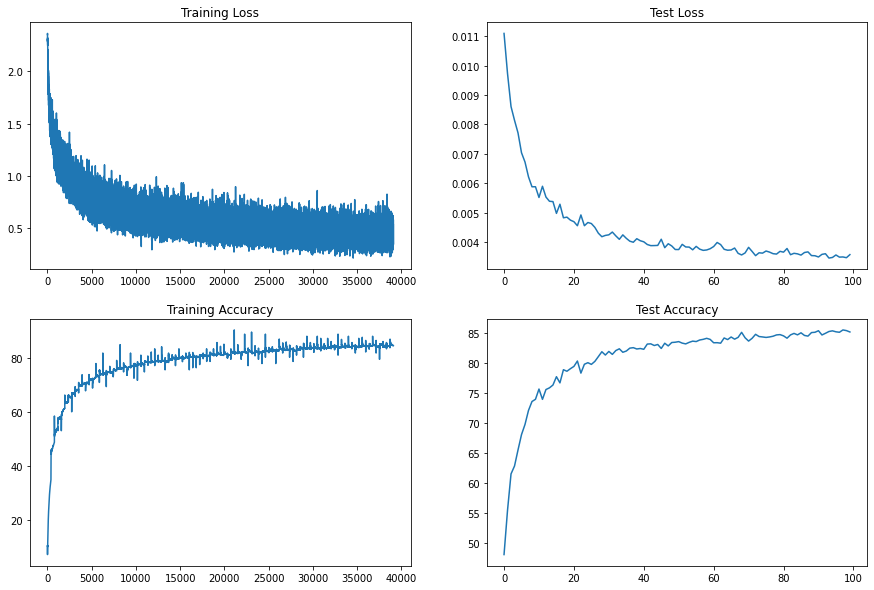

In [11]:
import matplotlib.pyplot as plt
plotting.plot_acc_loss(train_losses, train_acc, test_losses, test_acc)